# Predicting House Prices in Seattle

My project aims to create a machine learning model capable of predicting house prices in Seattle, Washington, USA. The model will leverage various features, including but not limited to the number of bedrooms, size of the house, and other relevant factors that will be detailed later on. The dataset used for training and testing the model consists of actual house prices from transactions that occurred in Seattle between August and December of 2022."

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import itertools

# Scikit-learn imports
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, mean_squared_log_error, precision_score, 
    recall_score, matthews_corrcoef, accuracy_score
)
from sklearn.model_selection import (
    learning_curve, validation_curve, train_test_split, KFold, 
    StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, 
    cross_validate, RepeatedStratifiedKFold
)
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    FunctionTransformer, MinMaxScaler, StandardScaler, 
    OneHotEncoder, OrdinalEncoder, LabelEncoder, KBinsDiscretizer
)
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree, datasets
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import LinearSVC, SVC, SVR

# Importing probability distributions for hyperparameter tuning
from scipy.stats import loguniform, beta, uniform

# Sequential Feature Selector from mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Imbalanced Learn imports for handling imbalanced datasets
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBPipeline

# Missing data visualization library
import missingno as msno

# Data visualization library
import matplotlib.pyplot as plt

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


## Loading the Data

The data is structured in a tabular format where each row corresponds to a house, and each column represents a feature describing the respective property.

In [ ]:
dataset = pd.read_csv("/work/train_corrupted.csv")

We separate the target column from the feature matrix.

In [ ]:
X = dataset.drop(labels='price',axis=1)
y = dataset['price']

Now, addressing missing values is crucial.

In [ ]:
X.isnull().sum(axis=0)/X.shape[0]

Unnamed: 0        0.000000
beds              0.197987
baths             0.277517
size              0.176846
size_units        0.000000
lot_size          0.185906
lot_size_units    0.185906
zip_code          0.082215
dtype: float64

<AxesSubplot: >

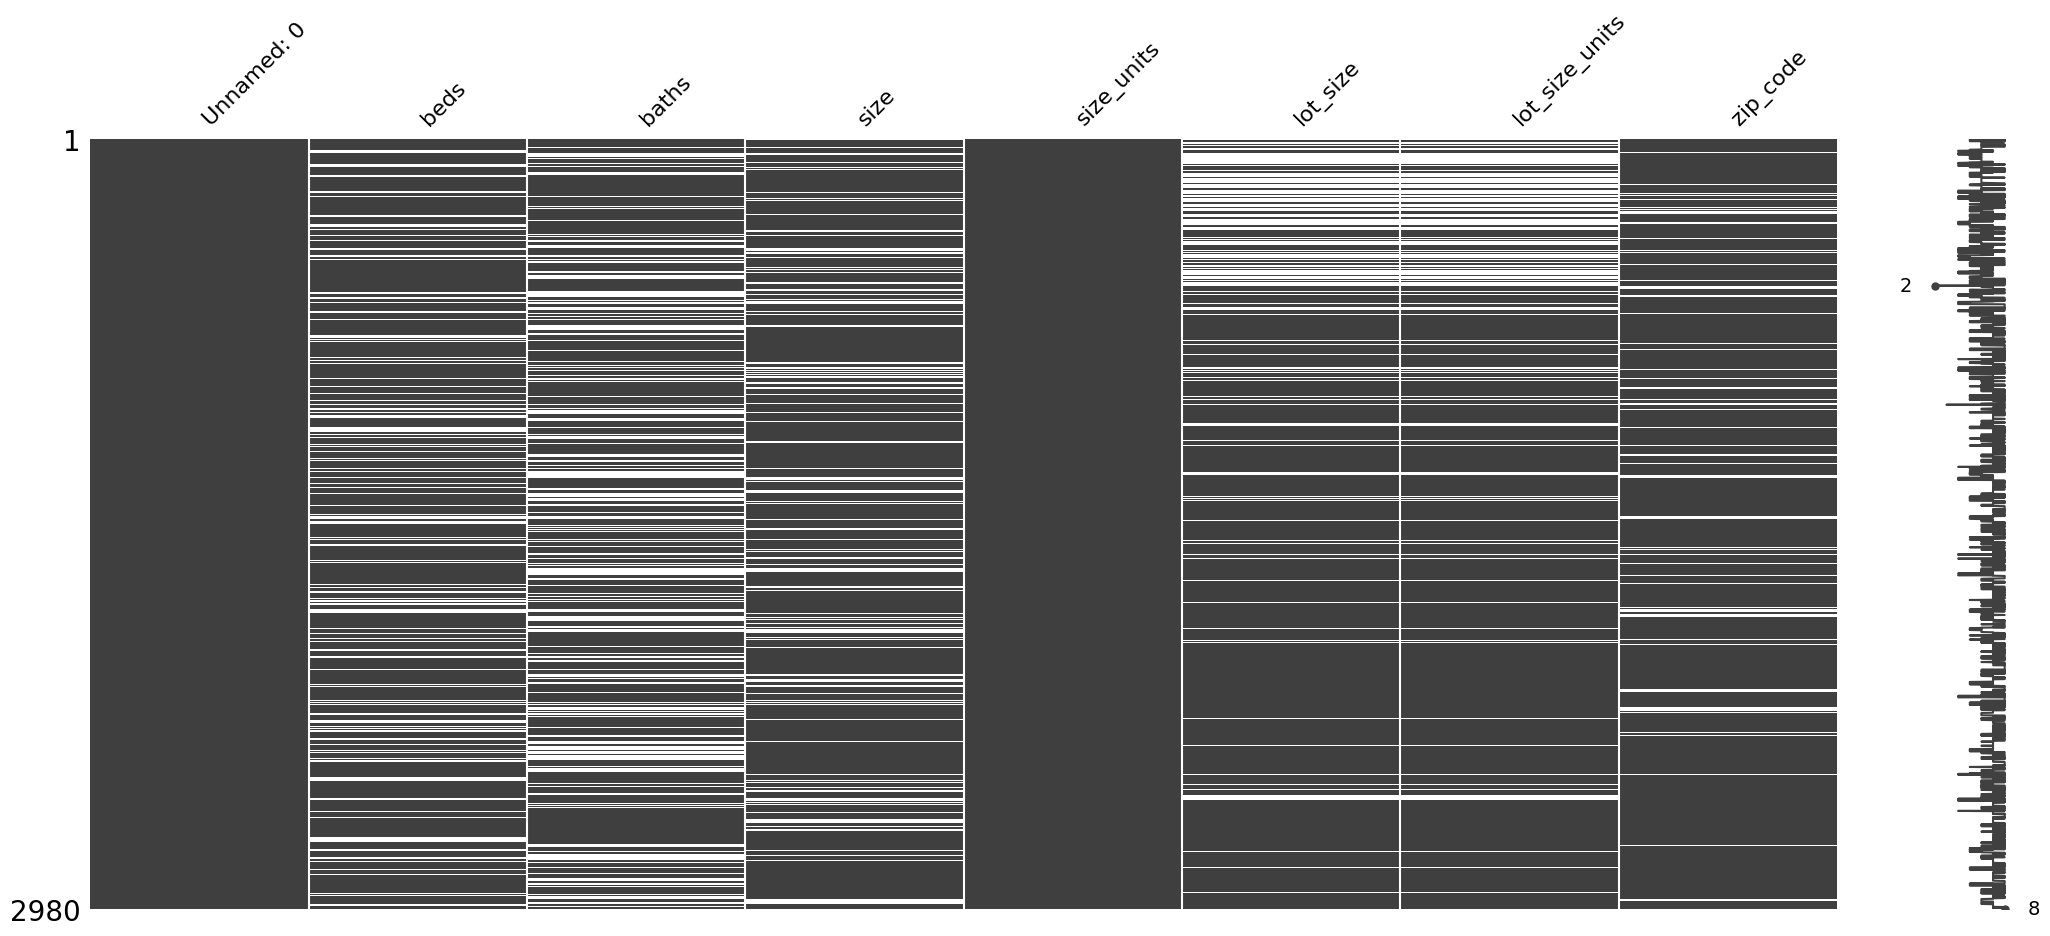

In [ ]:
msno.matrix(X)

Given the relatively moderate percentages of missing data, it is unnecessary to resort to column removal. Instead, our approach involves imputing the missing values to ensure a comprehensive dataset.

## Data Preprocessing

We proceed by defining the data transformation pipeline, outlining specific transformations for each feature. 

The transformation process for this case is as follows:
![](/work/Pipeline.png)

The columns not depicted in the diagram—namely, size-units and lot-size-units—will be excluded from further consideration as they each contain only a single unique value.

The 'lot-size' column contains values in acres, which we convert to square feet for consistency across all values. Consequently, the 'lot-size-units' column now holds a single value, rendering it unnecessary, and we proceed to discard it.

In [ ]:
# Finding indices where 'lot_size_units' is "acre"
indices = X.index[X['lot_size_units'] == "acre"]

# Iterating through the identified indices
for i in indices:
    # Converting 'lot_size' values from acres to square feet
    X.at[i, 'lot_size'] = X.loc[i, 'lot_size'] * 43560
    
    # Updating 'lot_size_units' to reflect the change from acres to square feet
    X.at[i, 'lot_size_units'] = X.loc[i, 'lot_size_units'].replace("acre", "sqft")

Now, we are prepared to construct various pipelines and assemble our ColumnTransformer.

In [ ]:
# Pipeline for handling missing values and scaling for 'beds' and 'baths'
pipeline_beds_baths = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('scaler', MinMaxScaler())  # Scale values using Min-Max scaling
])

# Pipeline for handling missing values and scaling for 'size' and 'lot_size'
pipeline_size_lotsize = Pipeline([
    ('imp', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Scale values using StandardScaler
])

# Pipeline for handling missing values, and one-hot encoding for 'zip_code'
pipeline_zipcode = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('hot', OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore'))  # One-hot encoding
])

# ColumnTransformer to apply different pipelines to specified columns
final_transformation = ColumnTransformer(transformers=[
    ('beds_bath', pipeline_beds_baths, ['beds', 'baths']),  # Apply 'pipeline_beds_baths' to 'beds' and 'baths'
    ('size', pipeline_size_lotsize, ['size', 'lot_size']),  # Apply 'pipeline_size_lotsize' to 'size' and 'lot_size'
    ('zipcode', pipeline_zipcode, ['zip_code'])  # Apply 'pipeline_zipcode' to 'zip_code'
],
remainder='drop',  # Drop any columns not specified in transformers
verbose_feature_names_out=False,  # Do not include verbose feature names
sparse_threshold=0  # Set the threshold for sparse matrix representation to 0
)

## Training and Test sets

We partition the entire dataset into training and test sets, allocating 30% of the instances to the test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=30, shuffle=True)

## Model Selection

In [ ]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.9)),
    ('classifier', DecisionTreeRegressor())
])

In [ ]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('beds_bath',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['beds', 'baths']),
                                                 ('size',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['size', 'lot_size']),
                                                 ('zipcode',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['zip_code'])],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.9)),
                ('classifier', DecisionTreeRegressor())])

In [ ]:
model_pipeline.predict(X_test)

array([  475000.        ,   635000.        ,   619000.        ,
        1240000.        ,   485000.        ,  1310000.        ,
        3050000.        ,   840000.        ,   730000.        ,
        1299000.        ,   630000.        ,   955000.        ,
         485000.        ,  1299950.        ,   595000.        ,
         425000.        ,   838000.        ,   369950.        ,
         535000.        ,   776000.        ,   699500.        ,
        1295000.        ,   309000.        ,   468000.        ,
        2250000.        ,   945000.        ,  1299000.        ,
         985000.        ,  1005000.        ,   905000.        ,
         449000.        ,  2080000.        ,   670000.        ,
         315000.        ,   638555.55555556,  1900000.        ,
         800000.        ,   630000.        ,  1880000.        ,
        1470000.        ,   849000.        ,   775000.        ,
        1075000.        ,  1725000.        ,   855000.        ,
         778000.        ,  1250000.     

In [ ]:
sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    }
]

classifier_configs = [
    {
        'classifier' : [RandomForestRegressor()],
        'classifier__n_estimators' : [10,50,100, 500],
        'classifier__max_depth' : [None, 1, 2, 3]
    },
    {
        'classifier' : [DecisionTreeRegressor()],
        'classifier__max_depth' : [None, 1, 2, 3]                             
    },
    {
        'classifier' : [GradientBoostingRegressor()],
        'classifier__n_estimators' : [100, 500, 1000], 
        'classifier__learning_rate' : loguniform(0.001, 0.05),
        'classifier__max_depth' : [None, 1, 2, 3],
        'classifier__min_samples_split': [5],
        'classifier__loss': ['squared_error']
    }
]

In [ ]:
'''
,
    {
        'dim_reduction': [SFS(estimator=DecisionTreeRegressor(), cv = None, scoring = 'neg_mean_squared_log_error')],
        'dim_reduction__estimator': [DecisionTreeRegressor(), RandomForestRegressor()] 
    }
{
        'classifier': [KNeighborsRegressor()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']
    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']
    },
    {
        'classifier' : [SVR(kernel = 'linear')]
    },
    {
        'classifier' : [SVR(kernel = 'poly', degree = 3)]
    }'''

"\n,\n    {\n        'dim_reduction': [SFS(estimator=DecisionTreeRegressor(), cv = None, scoring = 'neg_mean_squared_log_error')],\n        'dim_reduction__estimator': [DecisionTreeRegressor(), RandomForestRegressor()] \n    }\n{\n        'classifier': [KNeighborsRegressor()],\n        'classifier__n_neighbors': [3,5,7,9]\n    },\n    {\n        'classifier__eta0' : loguniform(0.001,100),\n        'classifier': [Perceptron()] ,\n        'classifier__max_iter': [1,5,10,15,50,100] ,\n        'classifier__class_weight' : [None, 'balanced']\n    },\n    {\n        'classifier': [LogisticRegression(solver='saga')],\n        'classifier__C' : loguniform(0.001,100),\n        'classifier__penalty': ['l1','l2'],\n        'classifier__class_weight' : [None, 'balanced']\n    },\n    {\n        'classifier' : [SVR(kernel = 'linear')]\n    },\n    {\n        'classifier' : [SVR(kernel = 'poly', degree = 3)]\n    }"

In [ ]:
all_configs = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs (key:value)

In [ ]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 27'

In [ ]:
all_configs[:2]

[{'sampler': [None],
  'dim_reduction': [None],
  'classifier': [RandomForestRegressor()],
  'classifier__n_estimators': [10, 50, 100, 500],
  'classifier__max_depth': [None, 1, 2, 3]},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [DecisionTreeRegressor()],
  'classifier__max_depth': [None, 1, 2, 3]}]

In [ ]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='neg_mean_squared_log_error'
)

In [ ]:
scores = cross_validate(rs, X_train, y_train, scoring='neg_mean_squared_log_error', cv=5, return_estimator=True, verbose=3, error_score='raise')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] END ......................................, score=-0.063 total time=12.1min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.1min remaining:    0.0s
[CV] END ......................................, score=-0.097 total time=10.5min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 22.6min remaining:    0.0s
[CV] END ......................................, score=-0.031 total time= 7.1min
[CV] END ......................................, score=-0.044 total time= 4.5min
[CV] END ......................................, score=-0.038 total time= 1.7min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 36.0min finished


In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
LinearDiscriminantAnalysis()
GradientBoostingRegressor(learning_rate=0.0319089009948352, max_depth=None,
                          min_samples_split=5, n_estimators=500) {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.0319089009948352, 'loss': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
-0.06273422260037492
----------
None
None
GradientBoostingRegressor(learning_rate=0.03343864100107895, max_depth=None,
                          min_samples_split=5) {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.03343864100107895, 'loss': 'squared_error', 'max_depth': None, 'max_features': None, '

In [ ]:
estimator.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('beds_bath',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['beds', 'baths']),
                                                 ('size',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['size', 'lot_size']),
                                                 ('zipcode',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['zip_code'])],
                                   verbose_feature_names_out=False)),
                ('sampler', None),
                ('dim_reduction', LinearDiscriminantAnalysis()),
                ('classifier', DecisionTreeRegressor())])

The best performing model is Decision Tree Regressor in combination with Linear Discriminant Analysis.

In [ ]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    msle_train = mean_squared_log_error(y_train, pred_train)
    msle_test = mean_squared_log_error(y_test, pred_test)
    print(f'MSLE on training set:{msle_train}, MSLE on test set:{msle_test}')

MSLE on training set:0.0010042689915991487, MSLE on test set:0.023427952444222758
MSLE on training set:0.0019340689028943738, MSLE on test set:0.02090063270492888
MSLE on training set:0.0010100794162585427, MSLE on test set:0.020581630263057676
MSLE on training set:0.0010042689528085185, MSLE on test set:0.020246552673475984
MSLE on training set:0.0010042689233901677, MSLE on test set:0.023465762950289654


## Refining the best model

Now that we have our best performing model, we tune its hyperparameters and refit the model to our dataset.

In [ ]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('dim_reduction', LDA()),
    ('classifier',DecisionTreeRegressor())
])

In [ ]:
params = {
        'classifier__max_depth' : [4]
}

In [ ]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring='neg_mean_squared_log_error'
)

In [ ]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('beds_bath',
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['beds',
                                                                                'baths']),
                                                                              ('size',
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer()),
                                                                                               ('sca...
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('hot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['zip_code'])],
                                                                verbose_feature_names_out=False)),
                                             ('dim_reduction',
                                              LinearDiscriminantAnalysis()),
                                             ('classifier',
                                              DecisionTreeRegressor())]),
                   n_iter=20,
                   param_distributions={'classifier__max_depth': [4]},
                   scoring='neg_mean_squared_log_error')

In [ ]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('beds_bath',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['beds', 'baths']),
                                                 ('size',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['size', 'lot_size']),
                                                 ('zipcode',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['zip_code'])],
                                   verbose_feature_names_out=False)),
                ('dim_reduction', LinearDiscriminantAnalysis()),
                ('classifier', DecisionTreeRegressor(max_depth=4))])

In [ ]:
mean_squared_log_error(y_test, rs_best.best_estimator_.predict(X_test))

0.12443063184394144

## Evaluation

Now, we can visualize the learning curve and the validation curve to quantify the bias/variance trade-off as a function of the size of the training set and the variation of the hyperparameter , for the case of Logistic Regression

In [ ]:
cls = rs_best.best_estimator_

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'neg_mean_squared_log_error',
                                                       shuffle = False)

In [ ]:
test_scores

array([[-0.8380655 ,         nan,         nan,         nan,         nan],
       [-0.38797973, -0.31180772, -0.34605229, -0.22604866, -0.28557083],
       [-0.21556301, -0.25398947, -0.24437088, -0.19371686, -0.17371096],
       [-0.22874125, -0.21078638, -0.11925446, -0.14247552, -0.10948316],
       [-0.19288743, -0.1692008 , -0.11255219, -0.12001879, -0.11431911],
       [-0.13532117, -0.16946241, -0.12529637, -0.12603568, -0.10922993],
       [-0.13377973, -0.16603201, -0.11400103, -0.1435026 , -0.17267945],
       [-0.1206433 , -0.18118855, -0.10327375, -0.1203852 , -0.13412605],
       [-0.11099161, -0.17855622, -0.09112394, -0.12875127, -0.10662552],
       [-0.10063045, -0.1820896 , -0.09687164, -0.11988123, -0.09664942],
       [-0.13828278, -0.16489403, -0.09282566, -0.11353221, -0.09532633]])

(0.04, 0.21)

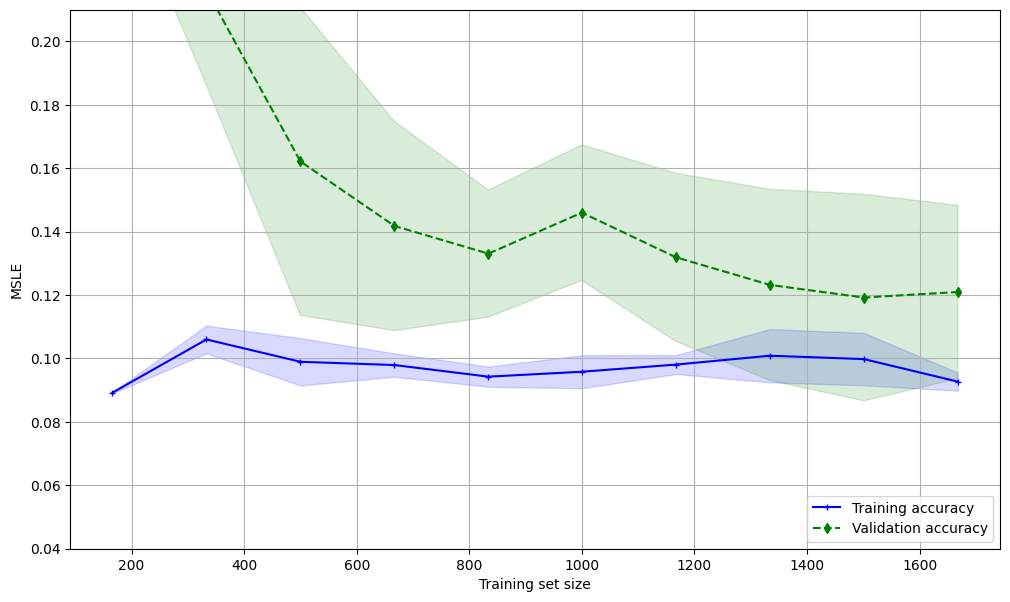

In [ ]:
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('MSLE')
ax.legend(loc='lower right')
ax.set_ylim([0.04, 0.21])

In [ ]:
range_max_depth = [1, 2, 3, 4, 5]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_max_depth, 
        param_name='classifier__max_depth',
        cv=5, 
        n_jobs=-1, 
        scoring='neg_mean_squared_log_error'
)

(0.9226808345905884, 5)

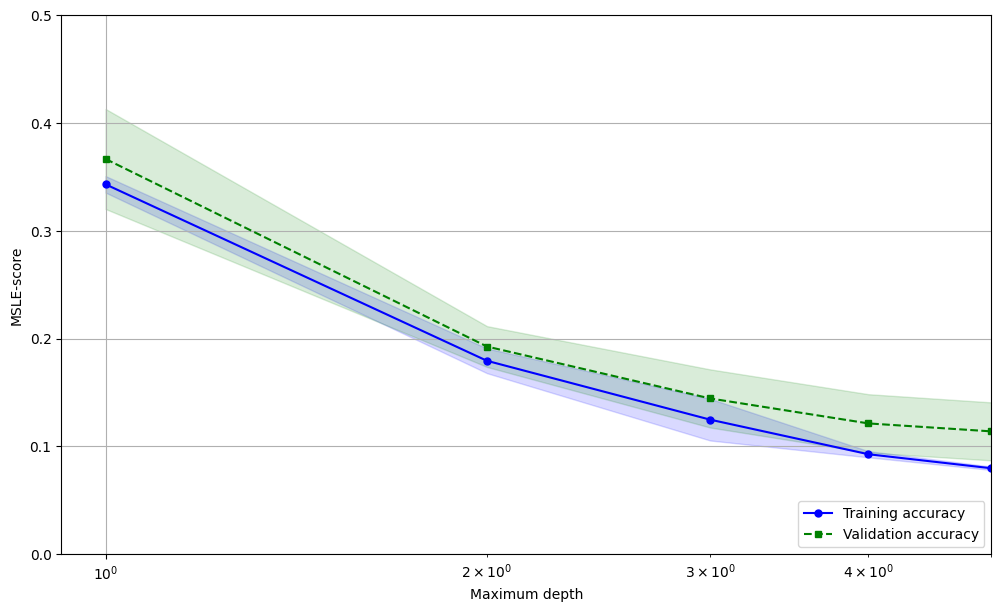

In [ ]:
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_max_depth, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_max_depth,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_max_depth, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_max_depth,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Maximum depth')
ax.set_ylabel('MSLE-score')
ax.legend(loc='lower right')
ax.set_ylim([0, 0.5])
ax.set_xscale('log')
ax.set_xlim([0,5])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddbda123-187a-4506-8b3f-d7f96240f999' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>